--- 分析整张图片 ---
正在对 30000 个像素进行K-Means聚类 (K=5)...
整张图的主体颜色是: RGB (122, 117, 116)，占比 21.83%
所有主体颜色及其占比如下:
  RGB (122, 117, 116): 21.83%
  RGB (62, 78, 98): 20.57%
  RGB (177, 163, 147): 20.56%
  RGB (24, 28, 44): 19.99%
  RGB (213, 202, 198): 17.05%


C:\Users\Joe Zheng\AppData\Local\Temp\ipykernel_56100\2769343905.py:79: UserWarning: Glyph 21344 (\N{CJK UNIFIED IDEOGRAPH-5360}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Joe Zheng\AppData\Local\Temp\ipykernel_56100\2769343905.py:79: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Joe Zheng\AppData\Local\Temp\ipykernel_56100\2769343905.py:79: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Joe Zheng\AppData\Local\Temp\ipykernel_56100\2769343905.py:79: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Joe Zheng\AppData\Local\Temp\ipykernel_56100\2769343905.py:79: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Joe Zheng\AppData\Local\Temp\ipykernel_56100\2769343905.py:79: Use

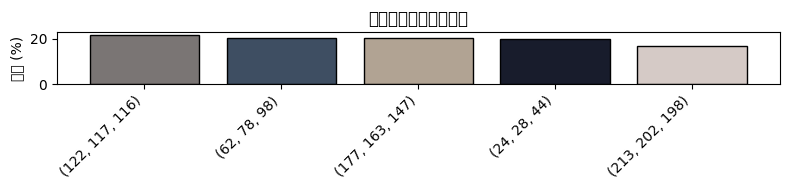

In [3]:
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def find_dominant_colors(image_path, k=5, region_box=None):
    """
    使用K-Means聚类找出图像或其区域内的主体颜色。

    :param image_path: 图像文件路径
    :param k: 希望找到的主体颜色数量
    :param region_box: 一个元组 (left, top, right, bottom) 用于裁剪区域，如果为None则分析整张图
    :return: 一个按占比降序排列的 (颜色RGB元组, 百分比) 列表
    """
    try:
        # 步骤 1: 加载图像并选定区域
        img = Image.open(image_path)
        if region_box:
            img = img.crop(region_box)
            
    except FileNotFoundError:
        print(f"错误：文件 '{image_path}' 未找到。")
        return []
    except Exception as e:
        print(f"打开或裁剪图像时出错: {e}")
        return []

    # 步骤 2: 数据预处理
    img = img.convert('RGB')  # 确保是RGB模式
    
    # 缩小图像以加快处理速度
    img.thumbnail((200, 200))
    
    # 将图像数据转换为NumPy数组
    pixels = np.array(img).reshape(-1, 3)

    # 步骤 3: 执行K-Means聚类
    print(f"正在对 {pixels.shape[0]} 个像素进行K-Means聚类 (K={k})...")
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(pixels)

    # 步骤 4: 提取并分析结果
    # 获取聚类中心（即主体颜色），并转换为整数
    dominant_colors = kmeans.cluster_centers_.astype(int)
    
    # 计算每个聚类包含的像素数量
    unique_labels, counts = np.unique(kmeans.labels_, return_counts=True)
    total_pixels = pixels.shape[0]

    # 步骤 5: 确定最终主体颜色并排序
    # 将颜色和它们的百分比配对
    color_info = []
    for i, label in enumerate(unique_labels):
        color = tuple(dominant_colors[label])
        percentage = (counts[i] / total_pixels) * 100
        color_info.append((color, percentage))
        
    # 按百分比降序排序
    sorted_colors = sorted(color_info, key=lambda x: x[1], reverse=True)

    return sorted_colors

def plot_colors(color_info):
    """
    可视化显示颜色及其占比。
    """
    colors = [info[0] for info in color_info]
    percentages = [info[1] for info in color_info]
    
    # 归一化颜色值到 [0, 1] for matplotlib
    plot_colors = np.array(colors) / 255.0
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 2), dpi=100)
    ax.bar(range(len(colors)), percentages, color=plot_colors, edgecolor='black', tick_label=[str(c) for c in colors])
    
    ax.set_ylabel("占比 (%)")
    ax.set_title("图像区域主体颜色分析")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# --- 使用示例 ---
if __name__ == '__main__':
    IMAGE_PATH = "backend/resource/bus.jpg"  # <-- 替换为你的图片路径

    # 示例1: 分析整张图片的主体颜色
    print("--- 分析整张图片 ---")
    # 将会找出5种主体颜色
    dominant_color_info_full = find_dominant_colors(IMAGE_PATH, k=5)
    if dominant_color_info_full:
        main_dominant_color = dominant_color_info_full[0]
        print(f"整张图的主体颜色是: RGB {main_dominant_color[0]}，占比 {main_dominant_color[1]:.2f}%")
        print("所有主体颜色及其占比如下:")
        for color, percentage in dominant_color_info_full:
            print(f"  RGB {color}: {percentage:.2f}%")
        plot_colors(dominant_color_info_full)

    print("\n" + "="*40 + "\n")